In [1]:
#%% markdown

#Name: Suman Raman Poudel
#Course Title: MSCS 634: Data Mining
# Lab Assignment: Association Rule Mining Using Apriori and FP-Growth


In [2]:
## Step 1: Data Preparation

### Dataset Selection
#Selected the **Online Retail Dataset** from UCI Machine Learning Repository. It contains transactional data from a UK retailer, with item descriptions for market basket analysis.

### Loading and Cleaning
# - Load from URL.
# - Remove missing values, cancellations, and non-positive quantities.
# - Standardize item descriptions.
# - Group into transactions (lists of items per invoice).

In [2]:
# Import libraries for data handling, visualization, and utilities
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
import time
import random

# Load dataset from UCI URL
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df = pd.read_excel(url)

# Cleaning steps:
# Drop rows with missing key fields
df = df.dropna(subset=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'CustomerID'])

# Exclude cancellations (start with 'C') and non-positive quantities
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[df['Quantity'] > 0]

# Standardize descriptions: strip whitespace and lowercase
df['Description'] = df['Description'].str.strip().str.lower()

# Create transactions: group by InvoiceNo, list unique items
transactions = df.groupby('InvoiceNo')['Description'].apply(list).tolist()
transactions = [list(set(trans)) for trans in transactions]  # Remove intra-transaction duplicates

# Print dataset stats
print(f"Number of transactions after cleaning: {len(transactions)}")
print(f"Number of unique items: {len(set(item for trans in transactions for item in trans))}")
print(f"Average transaction length: {sum(len(t) for t in transactions) / len(transactions):.2f}")

Number of transactions after cleaning: 18536
Number of unique items: 3866
Average transaction length: 20.92


In [5]:
### Estimate Frequent Itemset Size for Full Dataset
#Before proceeding to mining, estimate the size of L1 and C2 for a reasonable min_support_count (e.g., 100) to see why sampling is necessary.

In [3]:
# Estimation snippet for full dataset
def l1_size(transactions, min_support_count):
    c = Counter()
    for t in transactions: 
        c.update(set(t))
    return sum(1 for _, cnt in c.items() if cnt >= min_support_count)

n = l1_size(transactions, min_support_count=100)
print("L1 size:", n, "Estimated |C2| ~", n*(n-1)//2)

L1 size: 1174 Estimated |C2| ~ 688551


In [4]:
random.seed(42)  # For reproducibility
transactions_sample = random.sample(transactions, 200)
print(f"Sample size: {len(transactions_sample)} transactions")

Sample size: 200 transactions


In [8]:
### Exploratory Visualizations
# - Barplot: Top 20 frequent items.
# - Heatmap: Co-occurrences among top 20 items (full matrix too large).

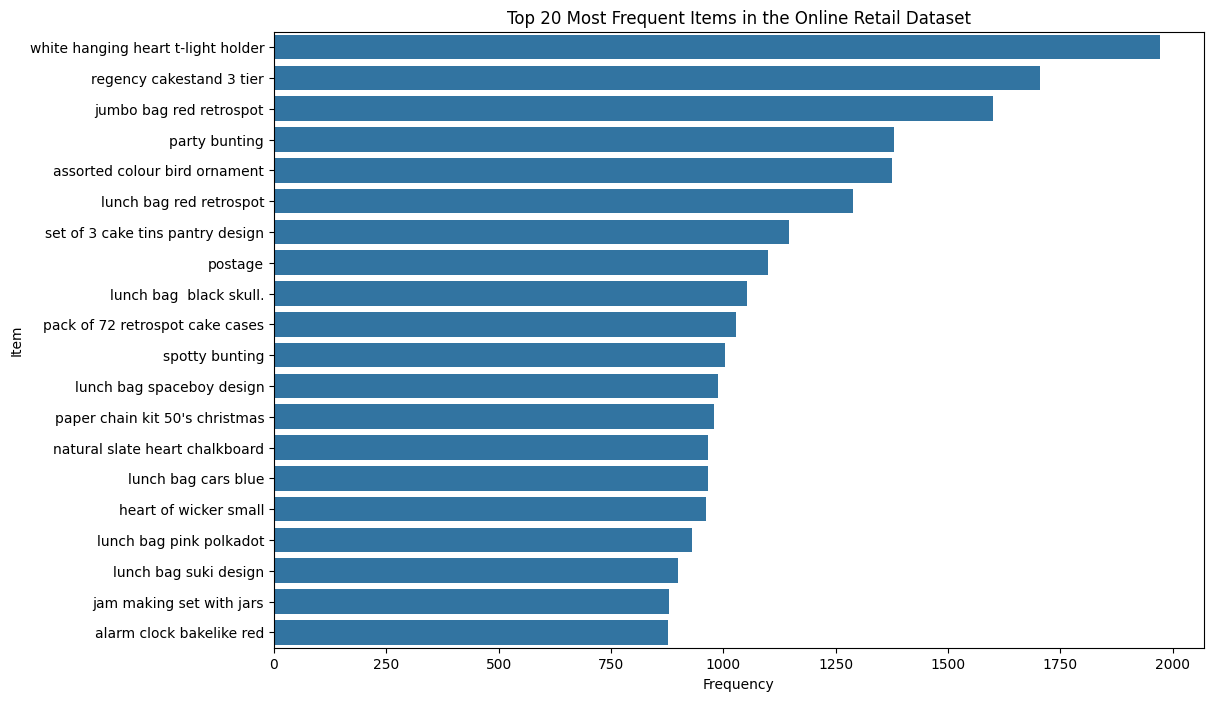

In [5]:
# Compute item frequencies for full dataset
item_counts = Counter(item for transaction in transactions for item in transaction)
df_counts = pd.DataFrame(list(item_counts.items()), columns=['Item', 'Count']).sort_values('Count', ascending=False).head(20)

# Barplot: Most frequent items
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Item', data=df_counts)
plt.title('Top 20 Most Frequent Items in the Online Retail Dataset')
plt.xlabel('Frequency')
plt.ylabel('Item')
plt.show()

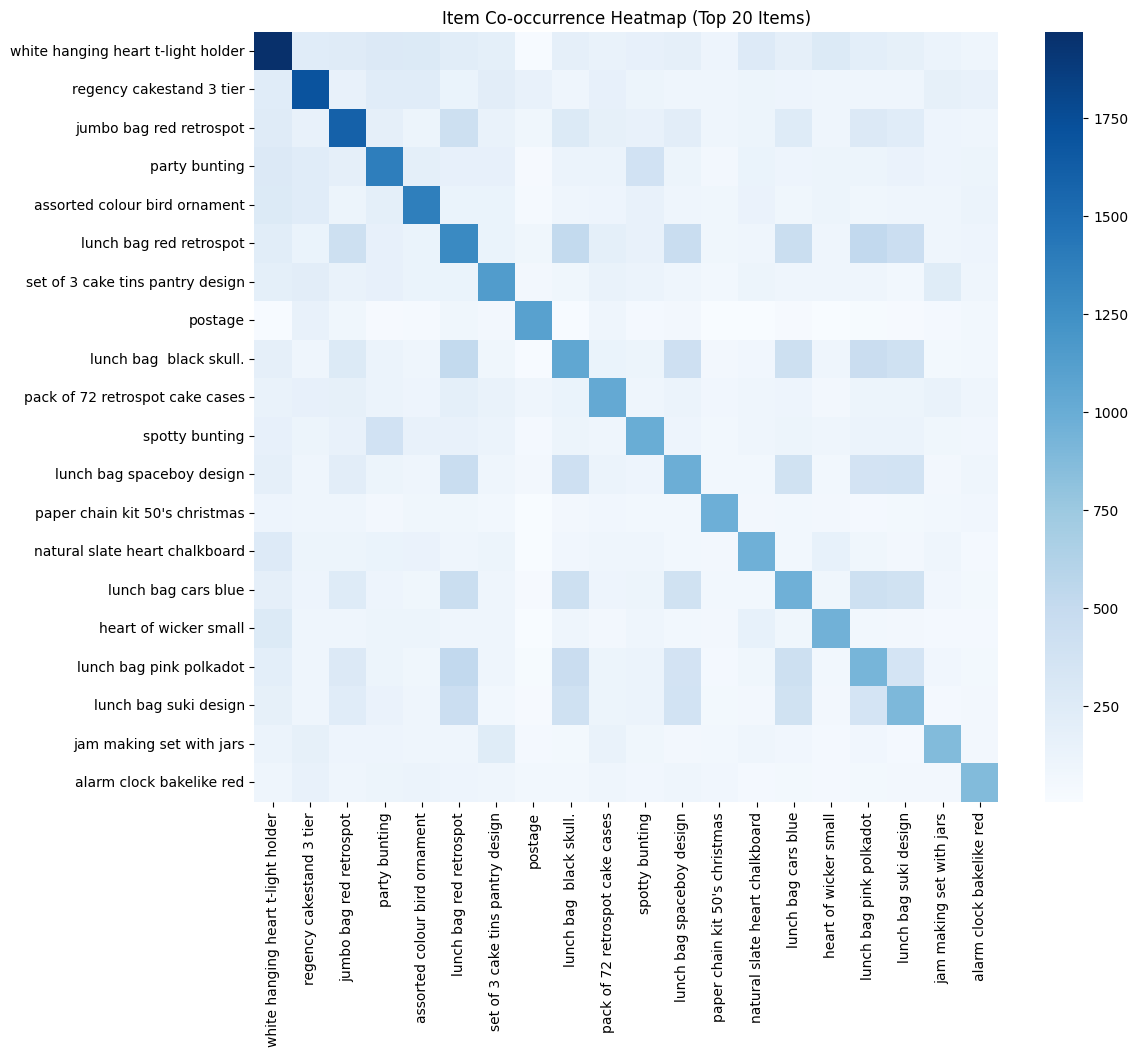

In [6]:
# Co-occurrence matrix for top 20 items (efficient subset)
top_items = df_counts['Item'].tolist()
df_onehot = pd.DataFrame(0, index=range(len(transactions)), columns=top_items)
for i, trans in enumerate(transactions):
    for item in trans:
        if item in top_items:
            df_onehot.loc[i, item] = 1
co_occ = df_onehot.T.dot(df_onehot)

# Heatmap: Item co-occurrences
plt.figure(figsize=(12, 10))
sns.heatmap(co_occ, annot=False, cmap='Blues')
plt.title('Item Co-occurrence Heatmap (Top 20 Items)')
plt.show()

In [7]:
## Step 2: Frequent Itemset Mining Using Apriori

# - Map items to IDs for faster processing.
# - Set min_support = 0.03 (increased for faster execution, count ~15) based on reduced sample size.
# - Implement Apriori: Generate candidates, count support, filter frequent sets.

In [8]:
# Map strings to integers for efficiency (on sample)
unique_items_sample = sorted(set(item for trans in transactions_sample for item in trans))
item_to_id = {item: i for i, item in enumerate(unique_items_sample)}
id_to_item = {i: item for item, i in item_to_id.items()}
data_set = [tuple(sorted(item_to_id[item] for item in trans)) for trans in transactions_sample]

min_support = 0.05  # Increased to reduce computation time
min_support_count = int(min_support * len(transactions_sample))
print(f"Min support count: {min_support_count}")

Min support count: 10


In [9]:
# Time the algorithm
start_time = time.time()

# L1: Frequent 1-itemsets
c1 = {}
for itemset in data_set:
    for i in itemset:
        c1[i] = c1.get(i, 0) + 1
l1 = {k: v for k, v in c1.items() if v >= min_support_count}

support = [l1]  # Levels of frequent itemsets
items = sorted(l1.keys())

k = 2
while True:
    # Candidate generation
    c_k = {tuple(sorted(combo)): 0 for combo in combinations(items, k)}
    
    # Support counting
    for itemset in data_set:
        for combo in combinations(itemset, k):
            sorted_combo = tuple(sorted(combo))
            if sorted_combo in c_k:
                c_k[sorted_combo] += 1
    
    # Filter frequent
    l_k = {k: v for k, v in c_k.items() if v >= min_support_count}
    if not l_k:
        break
    
    support.append(l_k)
    items = sorted(set(i for itemset in l_k for i in itemset))
    k += 1

apriori_time = time.time() - start_time
print(f"Apriori execution time: {apriori_time:.4f} seconds")

Apriori execution time: 1.1883 seconds


In [10]:
# Display frequent itemsets
print("\nFrequent Itemsets from Apriori (support):")
for level in support:
    for itemset, count in sorted(level.items(), key=lambda x: -x[1]):
        if not isinstance(itemset, tuple):
            real_itemset = (id_to_item[itemset],)
        else:
            real_itemset = tuple(sorted(id_to_item[i] for i in itemset))
        support_val = count / len(transactions_sample)
        print(f"{real_itemset}: {support_val:.4f}")


Frequent Itemsets from Apriori (support):
('jumbo bag red retrospot',): 0.1300
('regency cakestand 3 tier',): 0.1050
('party bunting',): 0.0850
('lunch bag red retrospot',): 0.0850
('set of 3 cake tins pantry design',): 0.0800
('white hanging heart t-light holder',): 0.0800
('spotty bunting',): 0.0750
('jumbo bag pink polkadot',): 0.0750
('lunch bag pink polkadot',): 0.0700
('jumbo bag vintage leaf',): 0.0700
('jumbo storage bag suki',): 0.0700
('assorted colour bird ornament',): 0.0650
('set of 4 pantry jelly moulds',): 0.0650
('set of 3 regency cake tins',): 0.0650
('scottie dog hot water bottle',): 0.0600
('lunch bag  black skull.',): 0.0600
('jumbo bag alphabet',): 0.0600
('wooden frame antique white',): 0.0550
('lunch bag woodland',): 0.0550
('set/5 red retrospot lid glass bowls',): 0.0550
('lunch bag cars blue',): 0.0550
("paper chain kit 50's christmas",): 0.0550
('jumbo bag strawberry',): 0.0550
('pack of 72 retrospot cake cases',): 0.0550
('baking set 9 piece retrospot',): 0.

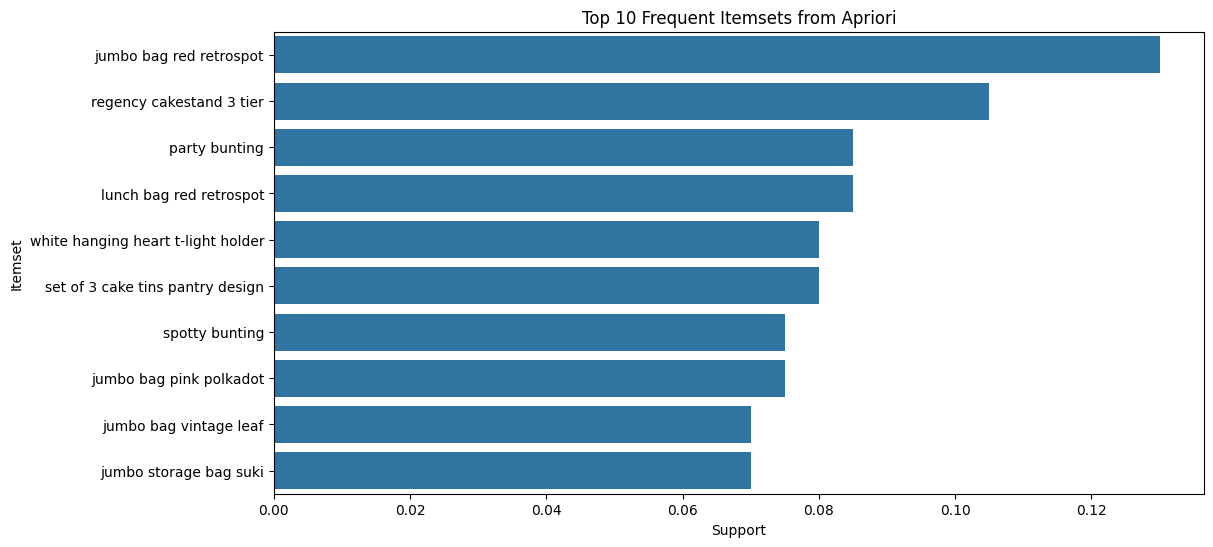

In [11]:
# Visualization: Top 10
freq_df = []
for level in support:
    for itemset, count in level.items():
        if not isinstance(itemset, tuple):
            real_itemset_str = id_to_item[itemset]
        else:
            real_itemset_str = ', '.join(sorted(id_to_item[i] for i in itemset))
        freq_df.append({'Itemset': real_itemset_str, 'Support': count / len(transactions_sample)})
freq_df = pd.DataFrame(freq_df).sort_values('Support', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='Support', y='Itemset', data=freq_df)
plt.title('Top 10 Frequent Itemsets from Apriori')
plt.xlabel('Support')
plt.ylabel('Itemset')
plt.show()

In [12]:
## Step 3: Frequent Itemset Mining Using FP-Growth

# - Implement FP-tree structure.
# - Use same min_support.
# - Compare efficiency with Apriori.

In [13]:
# FP-Node class
class FPNode:
    def __init__(self, item, count, parent):
        self.item = item
        self.count = count
        self.parent = parent
        self.children = {}
        self.next = None

# Helper: Update header link
def update_header(header_table, target_node):
    if header_table[target_node.item][1] is None:
        header_table[target_node.item][1] = target_node
    else:
        current = header_table[target_node.item][1]
        while current.next is not None:
            current = current.next
        current.next = target_node

# Helper: Update tree with transaction
def update_tree(sorted_items, in_tree, header_table, count):
    if sorted_items[0] in in_tree.children:
        in_tree.children[sorted_items[0]].count += count
    else:
        new_node = FPNode(sorted_items[0], count, in_tree)
        in_tree.children[sorted_items[0]] = new_node
        update_header(header_table, new_node)
    if len(sorted_items) > 1:
        update_tree(sorted_items[1:], in_tree.children[sorted_items[0]], header_table, count)

# Create initial FP-tree
def create_tree(transactions, min_support_count):
    header_table = {}
    for transaction in transactions:
        for item in transaction:
            header_table[item] = header_table.get(item, 0) + 1
    header_table = {k: [v, None] for k, v in header_table.items() if v >= min_support_count}
    if not header_table:
        return None, None
    freq_items = sorted(header_table.keys(), key=lambda x: (-header_table[x][0], x))
    root = FPNode('Null', 1, None)
    for transaction in transactions:
        filtered_transaction = [item for item in transaction if item in header_table]
        if filtered_transaction:
            filtered_transaction.sort(key=lambda x: (-header_table[x][0], x))
            update_tree(filtered_transaction, root, header_table, 1)
    return root, header_table

# Get prefix paths
def get_prefix_path(item, header_table):
    current = header_table[item][1]
    prefixes = []
    while current is not None:
        path = []
        asc_current = current.parent
        while asc_current.item != 'Null':
            path.append(asc_current.item)
            asc_current = asc_current.parent
        if path:
            prefixes.append((path[::-1], current.count))
        current = current.next
    return prefixes

# Create conditional tree
def create_conditional_tree(conditional_paths, min_support_count):
    header_table = {}
    for path, count in conditional_paths:
        for item in path:
            header_table[item] = header_table.get(item, 0) + count
    header_table = {k: [v, None] for k, v in header_table.items() if v >= min_support_count}
    if not header_table:
        return None, None
    root = FPNode('Null', 1, None)
    for path, count in conditional_paths:
        filtered_path = [item for item in path if item in header_table]
        if filtered_path:
            filtered_path.sort(key=lambda x: (-header_table[x][0], x))
            update_tree(filtered_path, root, header_table, count)
    return root, header_table

# Mine tree recursively
def mine_tree(header_table, min_support_count, pre_fix, freq_item_list):
    sorted_items = sorted(header_table.keys(), key=lambda x: header_table[x][0])
    for base_item in sorted_items:
        new_freq = pre_fix.copy()
        new_freq.add(base_item)
        freq_item_list.append(new_freq)
        conditional_paths = get_prefix_path(base_item, header_table)
        conditional_tree, conditional_header = create_conditional_tree(conditional_paths, min_support_count)
        if conditional_header is not None:
            mine_tree(conditional_header, min_support_count, new_freq, freq_item_list)

# Main FP-Growth function
def find_frequent_itemsets(transactions, min_support_count):
    tree, header_table = create_tree(transactions, min_support_count)
    freq_item_list = []
    mine_tree(header_table, min_support_count, set(), freq_item_list)
    return freq_item_list

In [14]:
# Time and run
start_time = time.time()

freq_itemsets = find_frequent_itemsets(transactions_sample, min_support_count)

fpgrowth_time = time.time() - start_time
print(f"FP-Growth execution time: {fpgrowth_time:.4f} seconds")

FP-Growth execution time: 0.0024 seconds


In [15]:
# Display with support
freq_with_support = []
for itemset in freq_itemsets:
    count = sum(1 for trans in transactions_sample if all(item in trans for item in itemset))
    freq_with_support.append((sorted(list(itemset)), count / len(transactions_sample)))

print("\nFrequent Itemsets from FP-Growth (support):")
for itemset, supp in sorted(freq_with_support, key=lambda x: -x[1]):
    print(f"{itemset}: {supp:.4f}")


Frequent Itemsets from FP-Growth (support):
['jumbo bag red retrospot']: 0.1300
['regency cakestand 3 tier']: 0.1050
['party bunting']: 0.0850
['lunch bag red retrospot']: 0.0850
['set of 3 cake tins pantry design']: 0.0800
['white hanging heart t-light holder']: 0.0800
['spotty bunting']: 0.0750
['jumbo bag pink polkadot']: 0.0750
['lunch bag pink polkadot']: 0.0700
['jumbo bag vintage leaf']: 0.0700
['jumbo storage bag suki']: 0.0700
['assorted colour bird ornament']: 0.0650
['set of 4 pantry jelly moulds']: 0.0650
['set of 3 regency cake tins']: 0.0650
['scottie dog hot water bottle']: 0.0600
['lunch bag  black skull.']: 0.0600
['jumbo bag alphabet']: 0.0600
['wooden frame antique white']: 0.0550
['set/5 red retrospot lid glass bowls']: 0.0550
['lunch bag woodland']: 0.0550
['lunch bag cars blue']: 0.0550
["paper chain kit 50's christmas"]: 0.0550
['jumbo bag strawberry']: 0.0550
['pack of 72 retrospot cake cases']: 0.0550
['baking set 9 piece retrospot']: 0.0550
['jumbo bag vintag

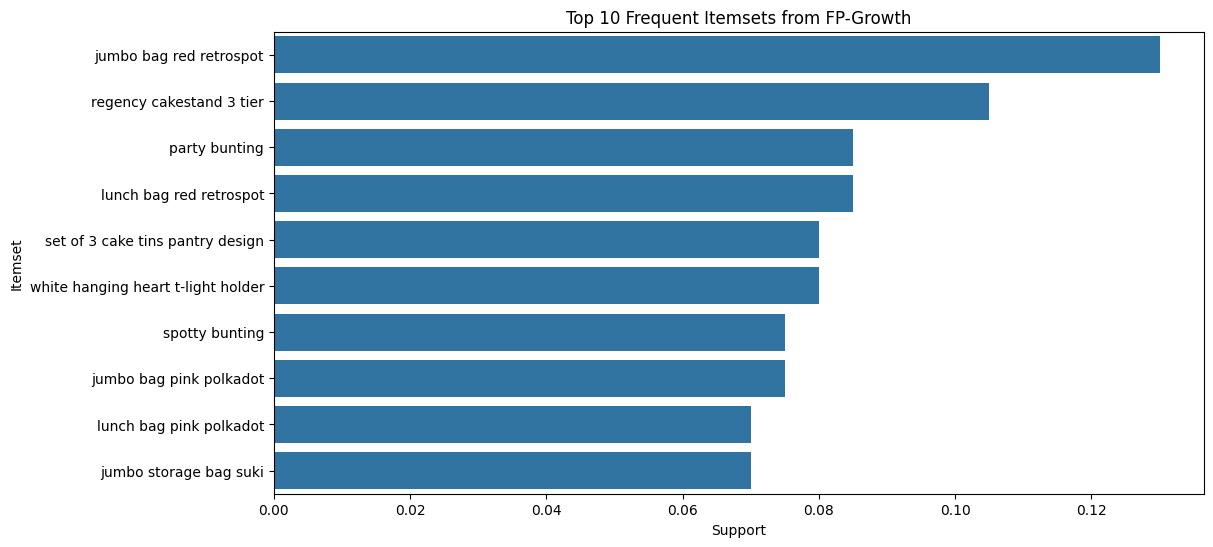

In [16]:
# Visualization: Top 10
freq_df_fp = pd.DataFrame({'Itemset': [', '.join(s) for s, _ in freq_with_support], 
                           'Support': [s for _, s in freq_with_support]}).sort_values('Support', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='Support', y='Itemset', data=freq_df_fp)
plt.title('Top 10 Frequent Itemsets from FP-Growth')
plt.xlabel('Support')
plt.ylabel('Itemset')
plt.show()

In [17]:
## Step 4: Generating and Analyzing Association Rules

# - Use frequent itemsets from Apriori (same as FP-Growth).
# - Min confidence = 0.6.
# - Compute support, confidence, lift.

In [18]:
# Support dict from Apriori
support_dict = {}
for level in support:
    for itemset, count in level.items():
        key = frozenset([itemset]) if not isinstance(itemset, tuple) else frozenset(itemset)
        support_dict[key] = count / len(transactions_sample)

min_conf = 0.6

# Generate rules
rules = []
for lev_idx in range(1, len(support)):
    for itemset, count in support[lev_idx].items():
        itemset_set = frozenset(itemset)
        for r in range(1, len(itemset)):
            for ante in combinations(itemset, r):
                ante_set = frozenset(ante)
                conse_set = itemset_set - ante_set
                ante_supp = support_dict[ante_set]
                conse_supp = support_dict[conse_set]
                supp = count / len(transactions_sample)
                conf = supp / ante_supp
                if conf >= min_conf:
                    lift = supp / (ante_supp * conse_supp)
                    real_ante = tuple(sorted(id_to_item[i] for i in ante))
                    real_conse = tuple(sorted(id_to_item[i] for i in conse_set))
                    rules.append((real_ante, real_conse, supp, conf, lift))

In [19]:
# Display sorted by confidence
print("Association Rules:")
for ante, conse, supp, conf, lift in sorted(rules, key=lambda x: -x[3]):
    print(f"{ante} -> {conse} (support: {supp:.4f}, confidence: {conf:.4f}, lift: {lift:.4f})")

Association Rules:
('lunch bag  black skull.',) -> ('lunch bag pink polkadot',) (support: 0.0550, confidence: 0.9167, lift: 13.0952)
('jumbo storage bag suki',) -> ('jumbo bag red retrospot',) (support: 0.0550, confidence: 0.7857, lift: 6.0440)
('lunch bag pink polkadot',) -> ('lunch bag  black skull.',) (support: 0.0550, confidence: 0.7857, lift: 13.0952)


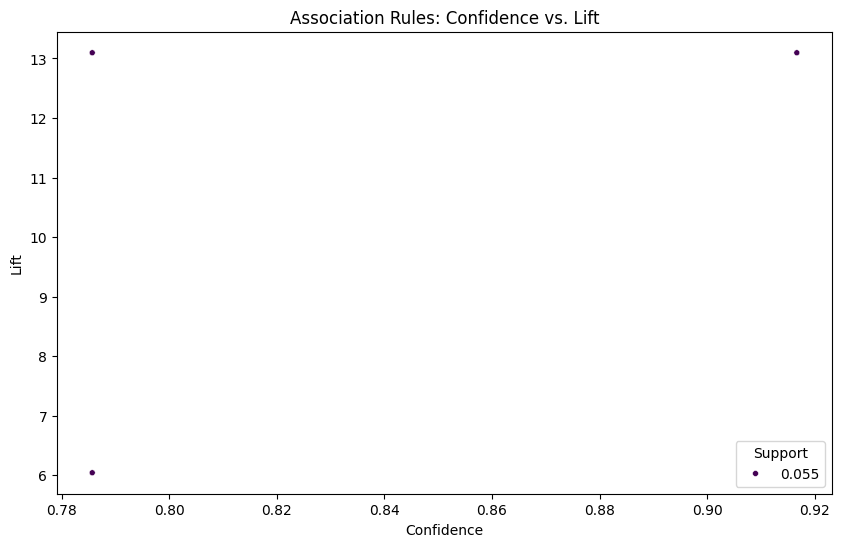

In [20]:
# Visualization: Scatter
rules_df = pd.DataFrame(rules, columns=['Antecedent', 'Consequent', 'Support', 'Confidence', 'Lift'])
rules_df['Antecedent'] = rules_df['Antecedent'].apply(lambda x: ', '.join(x))
rules_df['Consequent'] = rules_df['Consequent'].apply(lambda x: ', '.join(x))
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Confidence', y='Lift', data=rules_df, size='Support', hue='Support', palette='viridis')
plt.title('Association Rules: Confidence vs. Lift')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.show()